In [1]:
import dataset_utils as dataset

import torch as t

from ML_cup.pytorch import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    torch.set_default_device(torch.device("cuda"))


In [3]:
import pandas as pd

#column_names = ['ID', 
#                'INPUT_1', 'INPUT_2', 'INPUT_3', 'INPUT_4', 'INPUT_5', 'INPUT_6', 'INPUT_7', 'INPUT_8', 'INPUT_9', 'INPUT_10','INPUT_11','INPUT_12',
#                'TARGET_x', 'TARGET_y', 'TARGET_z']
#dataframe = pd.read_csv("../data/ML-CUP24-TR.csv", sep=',', comment='#', names=column_names, index_col= 'ID')
#dataframe.head()

In [4]:

dev_data = dataset.load_dataset("../data/ML-CUP24-TR.csv")
blind_data = dataset.load_dataset("../data/ML-CUP24-TS.csv")

In [5]:

# arrange the dataset into inputs and labels
from dataset_utils import arrange_datasets, train_val_kfold

X_dev, y_dev, X_blind = arrange_datasets(dev_data, blind_data)
train_folds, val_folds = train_val_kfold(X_dev, y_dev, folds=5, random_state=42)

In [6]:
# Split the dev data into train and validation with k-fold cross validation and minibatch
train_loaders, val_loaders, test_loader = dataset.torch_k_fold(dataset=dev_data, folds=5, batch_size=50)

# Grid search for the best parameters
Uses two slightly different lr schedulers

In [7]:
parameters = [
    {'optimizer': 'SGD', 'lr': [0.01, 0.001, 0.0001], 'weight_decay': [0.0, 0.001, 0.0005], 'momentum': [0.9, 0.75],
     'nesterov': [True, False]}
]
lr_scheduler_params = {'mode': 'min', 'factor': 0.75, 'patience': 5, 'cooldown': 3, 'verbose': False, 'min_lr': 1e-6}

In [8]:

# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLP, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders, scheduler=('ReduceLROnPlateau', lr_scheduler_params),
                                  verbose=False)

/home/alex/.virtualenvs/ML/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.2479108527302742, Val Loss: 0.32270185351371766
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.2325926385819912, Val Loss: 0.32012189328670504
Best Parameters: {'lr': 0.01, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}, Train Loss: 0.2325926385819912, Val Loss: 0.32012189328670504


Fold: 0
Train Epoch: 0 Loss: 27.67929244041443 Val Loss: 11.531982421875
Train Epoch: 1 Loss: 6.911876022815704 Val Loss: 5.142109394073486
Train Epoch: 2 Loss: 3.360641598701477 Val Loss: 4.312169551849365
Train Epoch: 3 Loss: 16.998804450035095 Val Loss: 7.296844959259033
Train Epoch: 4 Loss: 5.017548203468323 Val Loss: 6.269402027130127
Train Epoch: 5 Loss: 4.099062621593475 Val Loss: 3.1511433124542236
Train Epoch: 6 Loss: 2.9830172657966614 Val Loss: 2.0356922149658203
Train Epoch: 7 Loss: 2.4368216395378113 Val Loss: 14.88021183013916
Train Epoch: 8 Loss: 7.796687066555023 Val Loss: 2.7692811489105225
Train Epoch: 9 Loss: 2.0589020550251007 Val Loss: 1.8689923286437988
Train Epoch: 10 Loss: 1.2579897344112396 Val Loss: 1.5605926513671875
Train Epoch: 11 Loss: 0.9931230694055557 Val Loss: 0.89604252576828
Train Epoch: 12 Loss: 1.4642220884561539 Val Loss: 4.135096073150635
Train Epoch: 13 Loss: 3.826691120862961 Val Loss: 2.764138698577881
Train Epoch: 14 Loss: 1.5535671710968018 

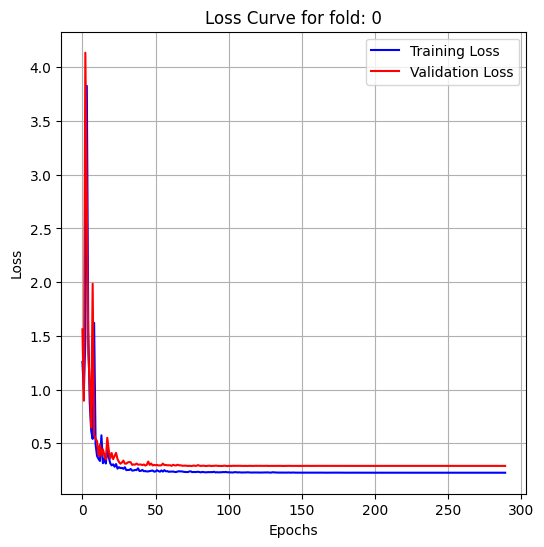

(0.22605082765221596, 0.28960034251213074)

In [9]:
# best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}

# retrain the model with the best parameters
best_model = MLP()
train_loader, val_loader = dataset.torch_split_dataset(dataset=dev_data, train_ratio=0.8, batch_size=50)
if best_pytorch_params['optimizer'] == 'SGD':
    optimizer = t.optim.SGD(best_model.parameters(), lr=best_pytorch_params['lr'],
                            weight_decay=best_pytorch_params['weight_decay'], momentum=best_pytorch_params['momentum'],
                            nesterov=best_pytorch_params['nesterov'])
else:
    optimizer = t.optim.Adam(best_model.parameters(), lr=best_pytorch_params['lr'],
                             weight_decay=best_pytorch_params['weight_decay'])

torch_train(model=best_model, optimizer=optimizer, train_loader=train_loader,
            val_loader=val_loader, epochs=300,
            verbose=True,
            scheduler=lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, cooldown=3,
                                                     verbose=True, min_lr=1e-6))

In [10]:
# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(best_model, test_loader))

Evaluating the model on the test set
0.6223108768463135


In [11]:
lr_scheduler_params = {'mode': 'min', 'factor': 0.25, 'patience': 10, 'cooldown': 3, 'verbose': False, 'min_lr': 1e-6}

# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLP, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders, scheduler=('ReduceLROnPlateau', lr_scheduler_params),
                                  verbose=False)

New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.22762366309762, Val Loss: 0.3262646168470383
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.23179653137922288, Val Loss: 0.32043197751045227
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0005, 'momentum': 0.9, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.22937093414366244, Val Loss: 0.3178933024406433
Best Parameters: {'lr': 0.01, 'weight_decay': 0.0005, 'momentum': 0.9, 'nesterov': False, 'optimizer': 'SGD'}, Train Loss: 0.22937093414366244, Val Loss: 0.3178933024406433


Fold: 0
Train Epoch: 0 Loss: 48.76517677307129 Val Loss: 47.485294342041016
Train Epoch: 1 Loss: 29.03250813484192 Val Loss: 17.562597274780273
Train Epoch: 2 Loss: 7.702345669269562 Val Loss: 5.796990871429443
Train Epoch: 3 Loss: 7.305899500846863 Val Loss: 7.286933898925781
Train Epoch: 4 Loss: 7.067942023277283 Val Loss: 5.569870471954346
Train Epoch: 5 Loss: 4.220724880695343 Val Loss: 6.571110248565674
Train Epoch: 6 Loss: 4.313904881477356 Val Loss: 6.436689853668213
Train Epoch: 7 Loss: 3.7254858016967773 Val Loss: 4.938983917236328
Train Epoch: 8 Loss: 3.183546781539917 Val Loss: 4.015509605407715
Train Epoch: 9 Loss: 2.8453341126441956 Val Loss: 3.663451910018921
Train Epoch: 10 Loss: 2.4687270522117615 Val Loss: 3.474893569946289
Train Epoch: 11 Loss: 2.2806458175182343 Val Loss: 3.0728273391723633
Train Epoch: 12 Loss: 2.067392110824585 Val Loss: 2.7294137477874756
Train Epoch: 13 Loss: 1.8639965057373047 Val Loss: 2.436156749725342
Train Epoch: 14 Loss: 1.6428337097167969 

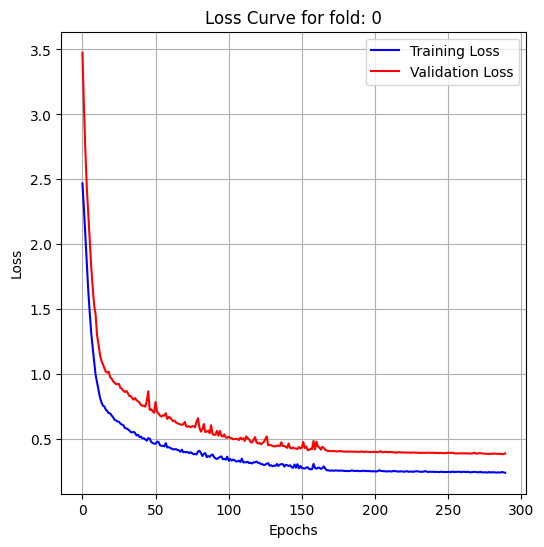

In [12]:
# changed scheduler compared to the previous cell, added nesterov
best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}

# retrain the model with the best parameters
best_model = MLP()
train_loader, val_loader = dataset.torch_split_dataset(dataset=dev_data, train_ratio=0.8, batch_size=50)
if best_pytorch_params['optimizer'] == 'SGD':
    optimizer = t.optim.SGD(best_model.parameters(), lr=best_pytorch_params['lr'],
                            weight_decay=best_pytorch_params['weight_decay'], momentum=best_pytorch_params['momentum'],
                            nesterov=best_pytorch_params['nesterov'])
else:
    optimizer = t.optim.Adam(best_model.parameters(), lr=best_pytorch_params['lr'],
                             weight_decay=best_pytorch_params['weight_decay'])

torch_train(model=best_model, optimizer=optimizer, train_loader=train_loader,
            val_loader=val_loader, epochs=300,
            verbose=True,
            scheduler=lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=10, cooldown=3,
                                                     verbose=True, min_lr=1e-6))
modelv1 = best_model


In [13]:
# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(best_model, test_loader))

Evaluating the model on the test set
0.7009825706481934


In [14]:
'''test_loader = DataLoader(CupDataset(blind_data))

# plot twist, it's only the inputs

# Evaluate the trained model on the test set
model = best_model
model.eval()  # Set the model to evaluation mode

outputs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        output = model(inputs)
        outputs.append(output)

outputs'''

"test_loader = DataLoader(CupDataset(blind_data))\n\n# plot twist, it's only the inputs\n\n# Evaluate the trained model on the test set\nmodel = best_model\nmodel.eval()  # Set the model to evaluation mode\n\noutputs = []\nwith torch.no_grad():\n    for inputs, labels in test_loader:\n        output = model(inputs)\n        outputs.append(output)\n\noutputs"

In [15]:
parameters = [
    {'optimizer': 'SGD', 'lr': [0.01, 0.001, 0.0001], 'weight_decay': [0.0, 0.001, 0.0005], 'momentum': [0.9, 0.75],
     'nesterov': [True, False]}
]
lr_scheduler_params = {'mode': 'min', 'factor': 0.75, 'patience': 5, 'cooldown': 3, 'verbose': False, 'min_lr': 1e-8}
# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLPv3, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders, scheduler=('ReduceLROnPlateau', lr_scheduler_params),
                                  verbose=False)

New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.23760203756392, Val Loss: 0.31753061413764955
Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}, Train Loss: 0.23760203756392, Val Loss: 0.31753061413764955


In [16]:
lr_scheduler_params = {'mode': 'min', 'factor': 0.25, 'patience': 10, 'cooldown': 3, 'verbose': False, 'min_lr': 1e-8}

In [17]:

# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLPv3, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders, scheduler=('ReduceLROnPlateau', lr_scheduler_params),
                                  verbose=False)

New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.3360640540719032, Val Loss: 0.5034938097000122
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.2697174079716206, Val Loss: 0.3719700902700424
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.25973482728004454, Val Loss: 0.3589520037174225
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.2244348295032978, Val Loss: 0.3309351742267609
Best Parameters: {'lr': 0.01, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}, Train Loss: 0.2244348295032978, Val Loss: 0.3309351742267609


Fold: 0
Train Epoch: 0 Loss: 54.57022571563721 Val Loss: 44.71430206298828
Train Epoch: 1 Loss: 41.27385711669922 Val Loss: 24.044401168823242
Train Epoch: 2 Loss: 17.496787428855896 Val Loss: 5.258060455322266
Train Epoch: 3 Loss: 6.794930696487427 Val Loss: 13.091230392456055
Train Epoch: 4 Loss: 9.898588180541992 Val Loss: 8.965746879577637
Train Epoch: 5 Loss: 5.544469356536865 Val Loss: 4.035893440246582
Train Epoch: 6 Loss: 4.5700225830078125 Val Loss: 3.705850601196289
Train Epoch: 7 Loss: 4.36337822675705 Val Loss: 3.409651279449463
Train Epoch: 8 Loss: 3.597367584705353 Val Loss: 3.8108818531036377
Train Epoch: 9 Loss: 3.2087804675102234 Val Loss: 3.3847031593322754
Train Epoch: 10 Loss: 2.84145724773407 Val Loss: 2.578524351119995
Train Epoch: 11 Loss: 2.5198816657066345 Val Loss: 2.107363700866699
Train Epoch: 12 Loss: 2.2344503700733185 Val Loss: 1.877299427986145
Train Epoch: 13 Loss: 1.9512965381145477 Val Loss: 1.6323344707489014
Train Epoch: 14 Loss: 1.7202922105789185 

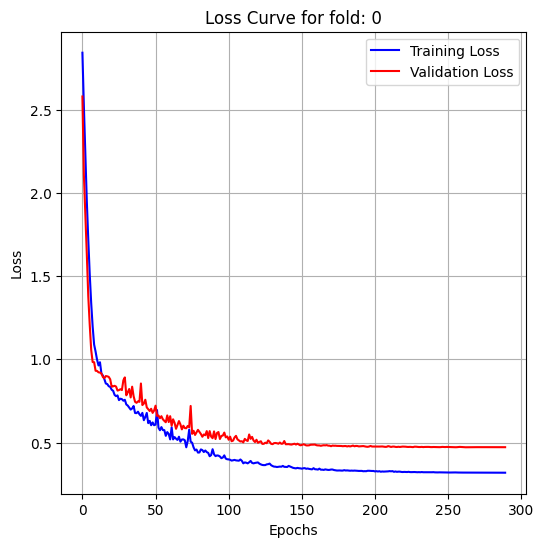

In [18]:
# retrain the model with the best parameters
best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}
best_model = MLPv3()
train_loader, val_loader = dataset.torch_split_dataset(dataset=dev_data, train_ratio=0.8, batch_size=50)
if best_pytorch_params['optimizer'] == 'SGD':
    optimizer = t.optim.SGD(best_model.parameters(), lr=best_pytorch_params['lr'],
                            weight_decay=best_pytorch_params['weight_decay'], momentum=best_pytorch_params['momentum'],
                            nesterov=best_pytorch_params['nesterov'])
else:
    optimizer = t.optim.Adam(best_model.parameters(), lr=best_pytorch_params['lr'],
                             weight_decay=best_pytorch_params['weight_decay'])

torch_train(model=best_model, optimizer=optimizer, train_loader=train_loader,
            val_loader=val_loader, epochs=300,
            verbose=True,
            scheduler=lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, cooldown=3,
                                                     verbose=True, min_lr=1e-6), clip=None)

modelv3 = best_model

In [19]:
# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(best_model, test_loader))

Evaluating the model on the test set
0.8167926669120789


In [20]:
def torch_pred(model, test_loader: DataLoader):
    # evaluate the model on the test set using mee metric
    predictions = []
    true = []
    with torch.no_grad():
        for data, true in test_loader:
            output = model(data)
            predictions.append(output)
    return predictions, true


In [21]:
# predict for model 1 and 3
predictions1, true = torch_pred(modelv1, val_loader)
predictions3, _ = torch_pred(modelv3, val_loader)

In [22]:
# check type of predictions

In [23]:
# find the a,b parameters that give the best result of a * model1 + b * model3
def find_best_a_b(predictions1, predictions3, y_dev):
    best_a = 0
    best_b = 0
    best_mee = 100
    
    for a in np.linspace(0, 1, 100):
        for b in np.linspace(0, 1, 100):
            if a + b == 1:
                pred = a * predictions1.cpu() + b * predictions3.cpu()
                mee = torch.norm(pred - y_dev, dim=-1).mean().item()
                print(mee)
                if mee < best_mee:
                    best_mee = mee
                    best_a = a
                    best_b = b
    return best_a, best_b, best_mee

find_best_a_b(torch.stack(predictions1), torch.stack(predictions3), true.cpu() )

1.0436370372772217
1.0410466194152832
1.0384635925292969
1.0358881950378418
1.0333205461502075
1.0282078981399536
1.025663137435913
1.0231263637542725
1.0205978155136108
1.0155644416809082
1.0130599737167358
1.0105640888214111
1.0080761909484863
1.0055969953536987
1.0031265020370483
0.998211145401001
0.9957666993141174
0.9933313131332397
0.9909048676490784
0.9884874820709229
0.9860793948173523
0.9836807250976562
0.9812915325164795
0.9789118766784668
0.9765422344207764
0.9741820693016052
0.9718320369720459
0.9694921970367432
0.967162549495697
0.9648432731628418
0.9625347852706909
0.9602369666099548
0.9579498767852783
0.9556742310523987
0.9534095525741577
0.9511564373970032
0.9489150047302246
0.9466854333877563
0.9444677829742432
0.9422628879547119
0.9400702118873596
0.9378902912139893
0.9357234239578247
0.9335697293281555
0.9314296245574951
0.9293028116226196
0.9271904230117798
0.925091564655304
0.9230073690414429
0.9209376573562622
0.9188826680183411
0.9168423414230347
0.91481703519821

(1.0, 0.0, 0.8434864282608032)

In [24]:
# predict for model 1 and 3
predictions1, true = torch_pred(modelv1, test_loader)
predictions3, _ = torch_pred(modelv3, test_loader)
alfa = 0.8787878787878789
beta = 0.12121212121212122

combined_predictions = alfa * torch.stack(predictions1) + beta * torch.stack(predictions3)

In [25]:
print('Original')
print(torch.norm(torch.stack(predictions1) - true, dim=-1).mean().item())
print(torch.norm(torch.stack(predictions3) - true, dim=-1).mean().item())

print('Linear Combination')
print(torch.norm(combined_predictions - true, dim=-1).mean().item())

Original
0.7009825706481934
0.8167926669120789
Linear Combination
0.7069146037101746
